In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# To scale the data using z-score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Metrics to evaluate the model
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold


import warnings
warnings.filterwarnings("ignore")


# For tuning the model
from sklearn.model_selection import GridSearchCV

In [2]:
water = pd.read_csv('water_potability.csv')


In [3]:
water.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [4]:
water.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [5]:
water.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [6]:
# Calculate the z-score for each data point.
z_scores = (water - water.mean()) / water.std(ddof=0)

# Define a threshold for outliers.
threshold = 3

# Find the indices of outliers.
outlier_indices = np.abs(z_scores) > threshold

# Print the outlier indices and values.
print(outlier_indices)


         ph  Hardness  Solids  Chloramines  Sulfate  Conductivity  \
0     False     False   False        False    False         False   
1     False     False   False        False    False         False   
2     False     False   False        False    False         False   
3     False     False   False        False    False         False   
4     False     False   False        False    False         False   
...     ...       ...     ...          ...      ...           ...   
3271  False     False   False        False    False         False   
3272  False     False   False        False    False         False   
3273  False     False   False        False    False         False   
3274  False     False   False        False    False         False   
3275  False     False   False        False    False         False   

      Organic_carbon  Trihalomethanes  Turbidity  Potability  
0              False            False      False       False  
1              False            False      Fa

In [7]:
water['Sulfate'] = water['Sulfate'].fillna(water['Sulfate'].mean())
water['ph'] = water['ph'].fillna(water['ph'].mean())
water['Trihalomethanes'] = water['Trihalomethanes'].fillna(water['Trihalomethanes'].mean())
water.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [8]:
row_zero = water[water['Potability'] == 0]
row_one = water[water['Potability'] == 1]

from sklearn.utils import resample
from sklearn.utils import shuffle

water_minority_upsampled = resample(row_one, replace=True, n_samples=1998)  #this is called over sampling
water_balanced = pd.concat([row_zero, water_minority_upsampled])

In [9]:
water.to_csv('update.csv', index=False)

In [10]:
Y = water_balanced['Potability']
X= water_balanced.drop(columns = ['Potability'])

In [11]:
# Split the resampled dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [12]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

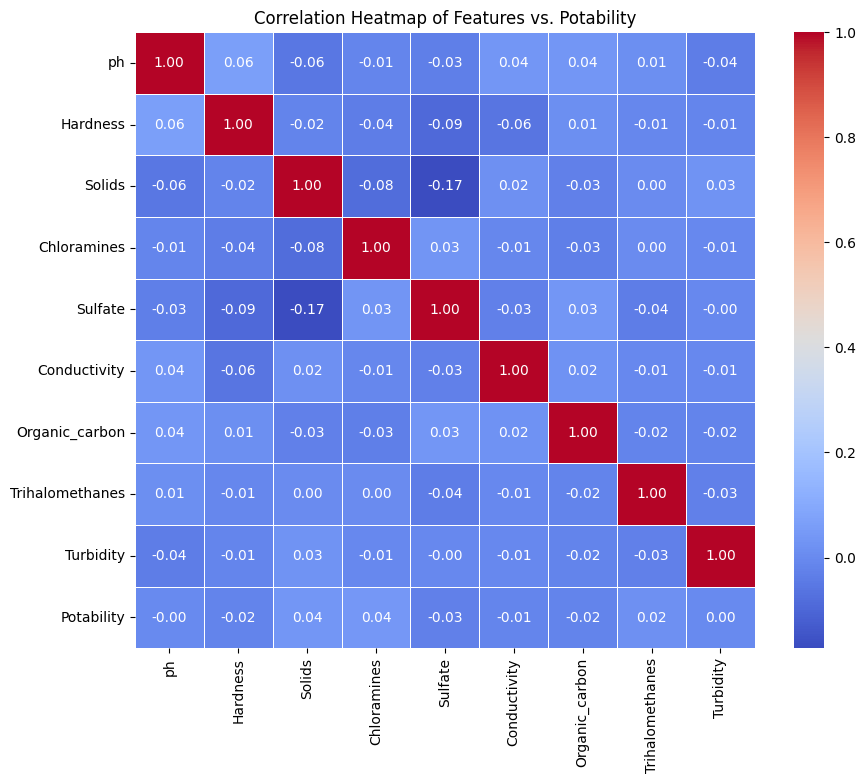

In [13]:
# @title Heatmap
corr_matrix = water_balanced.corr()

# Exclude the Potability column from the correlation matrix
corr_features = corr_matrix.drop('Potability', axis=1)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_features, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Features vs. Potability')
plt.show()

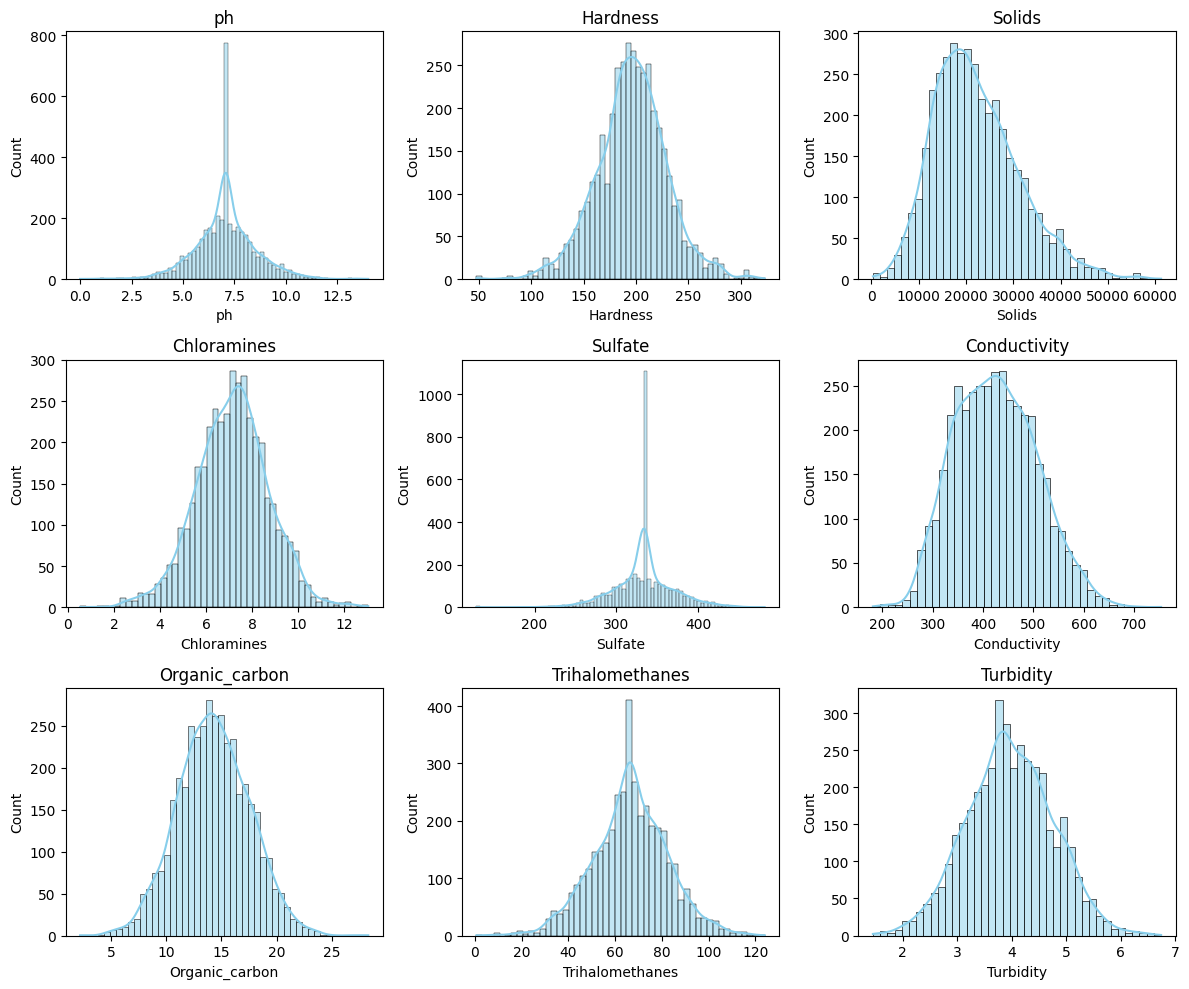

In [14]:
plt.figure(figsize=(12, 10))
for i, col in enumerate(water_balanced.columns[:-1]):
    plt.subplot(3, 3, i+1)
    sns.histplot(water_balanced[col], kde=True, color='skyblue')
    plt.title(col)
plt.tight_layout()
plt.show()

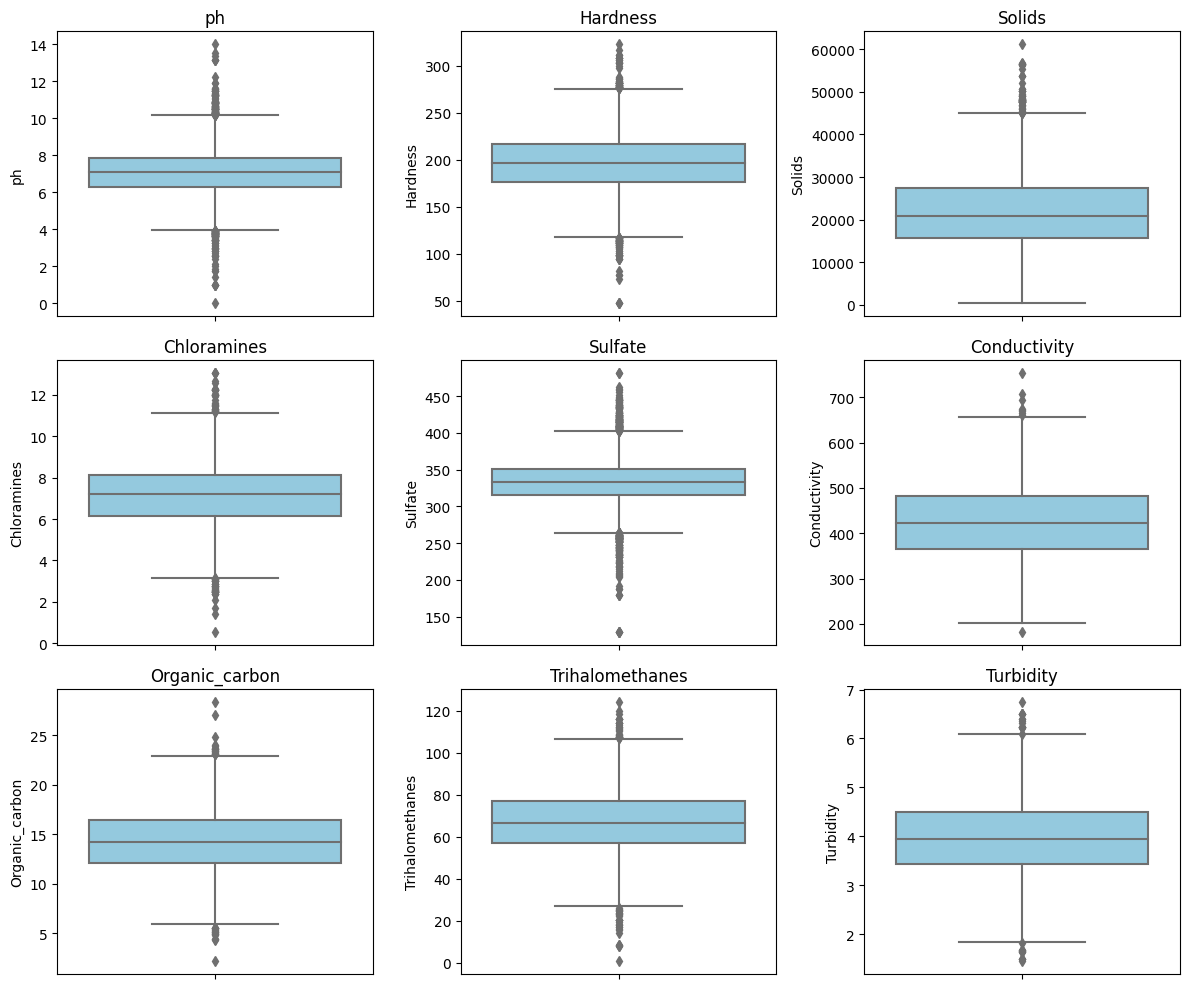

In [15]:
plt.figure(figsize=(12, 10))
for i, col in enumerate(water_balanced.columns[:-1]):
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=water_balanced[col], color='skyblue')
    plt.title(col)
plt.tight_layout()
plt.show()

In [16]:
# @title LogisticRegression

from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

In [17]:
# @title SVM

from sklearn.svm import SVC
svm_model = SVC(random_state=42)
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)

In [18]:
# @title DecisionTree

from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(X_train_scaled, y_train)
y_pred_clf = clf.predict(X_test_scaled)


In [19]:

# Calculate the confusion matrix for each model
lr_cm = confusion_matrix(y_test, y_pred_lr)
svm_cm = confusion_matrix(y_test, y_pred_svm)
clf_cm = confusion_matrix(y_test, y_pred_clf)

# Print the confusion matrices
print("Logistic Regression Confusion Matrix:\n", lr_cm)
print("SVM Confusion Matrix:\n", svm_cm)
print("Decision Tree Confusion Matrix:\n", clf_cm)


Logistic Regression Confusion Matrix:
 [[189 226]
 [151 234]]
SVM Confusion Matrix:
 [[281 134]
 [131 254]]
Decision Tree Confusion Matrix:
 [[285 130]
 [ 53 332]]


In [20]:
acc = accuracy_score(y_test,y_pred_lr)
acc2= accuracy_score(y_test,y_pred_svm)
acc3 = accuracy_score(y_test, y_pred_clf)
print("Accuracy:", acc)
print("Accuracy:", acc2)
print("Accuracy:", acc3)

Accuracy: 0.52875
Accuracy: 0.66875
Accuracy: 0.77125


In [22]:
# # @title Hyperparameter tuning
# # Define the parameter grid to search
from sklearn.model_selection import  GridSearchCV

param_grid = {
     'C': [0.1, 1, 10, 100],
     'gamma': ['scale', 'auto', 0.01, 0.1, 1,10],
     'kernel': ['linear', 'rbf', 'poly']
 }

# # Initialize the SVM classifier
svm = SVC()

# # Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# # Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


In [21]:

param_grid = {
    'C': [0.1, 1, 10],
     'penalty': ['l1', 'l2'],
     'solver': ['liblinear', 'saga'],  # Use 'liblinear' or 'saga' for l1 penalty
    'class_weight':['balanced','unbalanced'],
     'random_state':[0,42]
}

log_reg = LogisticRegression(max_iter=1000)

# # Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

# # Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# # Evaluate the model with best hyperparameters
best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test_scaled, y_test)
print("Accuracy:", accuracy)

Best Hyperparameters: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 0, 'solver': 'liblinear'}
Accuracy: 0.54125


In [22]:
best_params_lr = {
    'C':0.1,
    'penalty':'l1',
    'solver':'saga',
    'class_weight':'balanced',
    'random_state':42

}
log=LogisticRegression(  C=best_params_lr['C'],
    solver=best_params_lr['solver'],
penalty=best_params_lr['penalty'],
class_weight=best_params_lr['class_weight'],
                         random_state=42)
log.fit(X_train_scaled,y_train)
y_pred_lr=log.predict(X_test_scaled)
accuracy_log=accuracy_score(y_test,y_pred_lr)
print("Accuracy",accuracy_log)


Accuracy 0.54125


In [23]:
best_params_svm = {
    'C': 1,
    'gamma': 10,
    'kernel': 'rbf'
}
svm=SVC(
    C=best_params_svm['C'],
    gamma=best_params_svm['gamma'],
    kernel=best_params_svm['kernel'])
svm.fit(X_train_scaled, y_train)
accuracy_svm = svm.score(X_test_scaled, y_test)
print("Accuracy:", accuracy_svm)

Accuracy: 0.87875


In [24]:
params_decision_tree = {'min_samples_split': [2, 10, 30, 50], 'max_depth': [None, 10, 20, 30]}
best_params_decision = {
    'min_samples_split': 2,
    'max_depth':None
}

In [25]:
clf = DecisionTreeClassifier(
    min_samples_split=best_params_decision['min_samples_split'],
    max_depth=best_params_decision['max_depth']
)
clf.fit(X_train_scaled,y_train)
y_pred=clf.predict(X_test_scaled)
acc_dc=accuracy_score(y_test,y_pred)
print("Accuracy:",acc_dc)


Accuracy: 0.7625


In [26]:
# Initialize the kNN classifier
k = 1
knn = KNeighborsClassifier(n_neighbors=k)

# Train the classifier
knn.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = knn.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7775


In [27]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.845


In [28]:
param_rf = {
    'n_estimators': randint(50, 200),
    'max_depth': [None] + list(randint(1, 20).rvs(10)),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5)
}

rf_classifier1 = RandomForestClassifier(random_state=42)

# Perform Random Search with 5-fold cross-validation
random_search = RandomizedSearchCV(estimator=rf_classifier1, param_distributions=param_rf, n_iter=100, cv=5, random_state=42,n_jobs =-1)
random_search.fit(X_train_scaled, y_train)

# Best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Make predictions on the test set using the best model
best_rf_model = random_search.best_estimator_
y_pred = best_rf_model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 97}
Best Score: 0.7931817292644758
Accuracy: 0.835


In [29]:
#Cross Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf_classifier1, X, Y, cv=skf)
print(f"Cross-Validation Scores: {scores}")
print(f"Mean Accuracy: {scores.mean():.2f} ± {scores.std():.2f}")

Cross-Validation Scores: [0.8275     0.84480601 0.84480601 0.82728411 0.8485607 ]
Mean Accuracy: 0.84 ± 0.01


In [30]:
import joblib
file='dc'
joblib.dump(clf,"dc")
model=joblib.load(open("dc",'rb'))

In [31]:
import joblib
file='svm'
joblib.dump(svm,"svm")
model=joblib.load(open("svm",'rb'))

In [32]:
import joblib
file='log'
joblib.dump(log,"log")
model=joblib.load(open("log",'rb'))

In [33]:
import joblib
file='kNN'
joblib.dump(knn,"kNN")
model=joblib.load(open("kNN",'rb'))

In [34]:
import joblib
file='randomForest'
joblib.dump(rf_classifier,"randomForest")
model=joblib.load(open("randomForest",'rb'))